## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [3]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


In [4]:
task = 'OpenDrawer'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-14 13:09:50.609 | INFO     |  Loading dataset(s): 
2024-08-14 13:09:50.609 | INFO     |    Initializing datasete using /home/hartzj/VinDihsl/MT-GMM/data/OpenDrawer/demos/metadata.json
2024-08-14 13:09:50.615 | INFO     |    Extracted gt object labels [81, 83, 88, 93]
2024-08-14 13:09:50.615 | INFO     |    Extracted tsdf object labels []
2024-08-14 13:09:50.616 | INFO     |    Done! Data contains 5 trajectories.


In [5]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [6]:
observations = scene_data.get_demos(**gt_pose_config, indeces=[0, 2, 3, 4])

n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)

2024-08-14 13:09:53.387 | INFO     |  Subsampling to length 102 using strategy mean-length.


In [7]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=1,

    trans_cov_mask_t_pos_corr = False,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=1e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.49,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=5,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [8]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-14 13:09:53.466 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:09:53.467 | INFO     |  Performing fitting actions: [INIT]
2024-08-14 13:09:53.467 | INFO     |  Segmenting trajectories


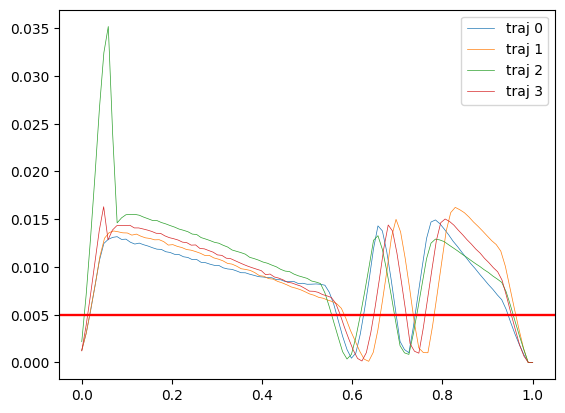

2024-08-14 13:09:53.565 | INFO     |  Creating segement of demos.
2024-08-14 13:09:53.566 | INFO     |  Subsampling to length 61 using strategy mean-length.
2024-08-14 13:09:53.567 | INFO     |  Creating segement of demos.
2024-08-14 13:09:53.568 | INFO     |  Subsampling to length 13 using strategy mean-length.
2024-08-14 13:09:53.568 | INFO     |  Creating segement of demos.
2024-08-14 13:09:53.569 | INFO     |  Subsampling to length 28 using strategy mean-length.
2024-08-14 13:09:53.569 | INFO     |  ... created 3 segments
2024-08-14 13:09:53.569 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:09:53.569 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:09:53.571 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2024-08-14 13:09:53.572 | INFO     |    Changing number of components to 11
2024-08-14 13:09:53.572 | INFO     |    Model init ...


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-14 13:09:53.740 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:09:53.740 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2024-08-14 13:09:53.951 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-14 13:09:53.951 | INFO     |  obj000     score (rel):     -1 (0.999)
2024-08-14 13:09:53.952 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:09:53.953 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:09:53.953 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:09:53.957 | INFO     |    Changing number of components to 5


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:09:54.019 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:09:54.019 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:09:54.100 | INFO     |  ee_init    score (rel):     -0 (0.002)
2024-08-14 13:09:54.101 | INFO     |  obj000     score (rel):     -1 (1.000)
2024-08-14 13:09:54.101 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:09:54.102 | INFO     |    Fitting candidate frame 1/2
2024-08-14 13:09:54.102 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:09:54.221 | INFO     |    Fitting candidate frame 2/2
2024-08-14 13:09:54.222 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:09:54.307 | INFO     |  ee_init    score (rel):     -0 (0.003)
2024-08-14 13:09:54.308 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:09:54.308 | INFO     |  Segmented trajs into 3 segments
2024-08-14 13:09:54.310 | INFO     |  Frame score (abs):
            ee_init    obj000
Segment 0 -0.998689 -0.997889
Segment 1 -0.002418 -0.998584
Segment 2 -0.002543 -0.998734
2024-08-14 13:09:54.311 | INFO     |  Frame score (rel):
            ee_init    obj000
Segment 0  1.000000  0.999198
Segment 1  0.002421  1.000000
Segment 2  0.002546  1.000000


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-14 13:09:54.321 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

((array([[2.25e+19, 2.15e+19, 5.13e+18, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.02e+16, 4.98e+16, 1.35e+17, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.57e+09, 2.21e+10, 2.03e+11, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.51e+10, 9.12e+08, 5.40e+07],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.32e+17, 1.58e+17, 5.01e+16],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 7.69e+18, 1.14e+19, 6.80e+18]]),
  array([[8.89e+11, 9.38e+11, 3.71e+11, 6.09e+10, 3.78e+09, 6.87e+07,
          2.19e+05, 5.16e+01, 4.18e-04, 2.37e-10, 3.82e-17, 6.77e-24,
          3.69e-30, 7.59e+11, 9.46e+11, 3.77e+11, 6.16e+10, 4.08e+09,
          1.00e+08, 6.64e+05, 1.88e+01, 6.91e-05, 2.46e-11, 4.15e-18,
          1.20e-24, 1.55e-30, 9.23e+11, 9.02e+11, 3.71e+11, 5.82e+10,
          2.90e+09, 3.16e+07, 4.15e+04, 2.86e+00, 1.19e-05, 8.62e-12,
          3.30e-18, 1.61e-24, 2.01e-30, 9.46e+11, 9.07e+11, 3.68e+11,
          6.07e+10, 3.77e+09, 6.81e+07

In [9]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-14 13:09:54.884 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-14 13:09:54.950 | WARNING  |  Skippig NaN Gaussians.


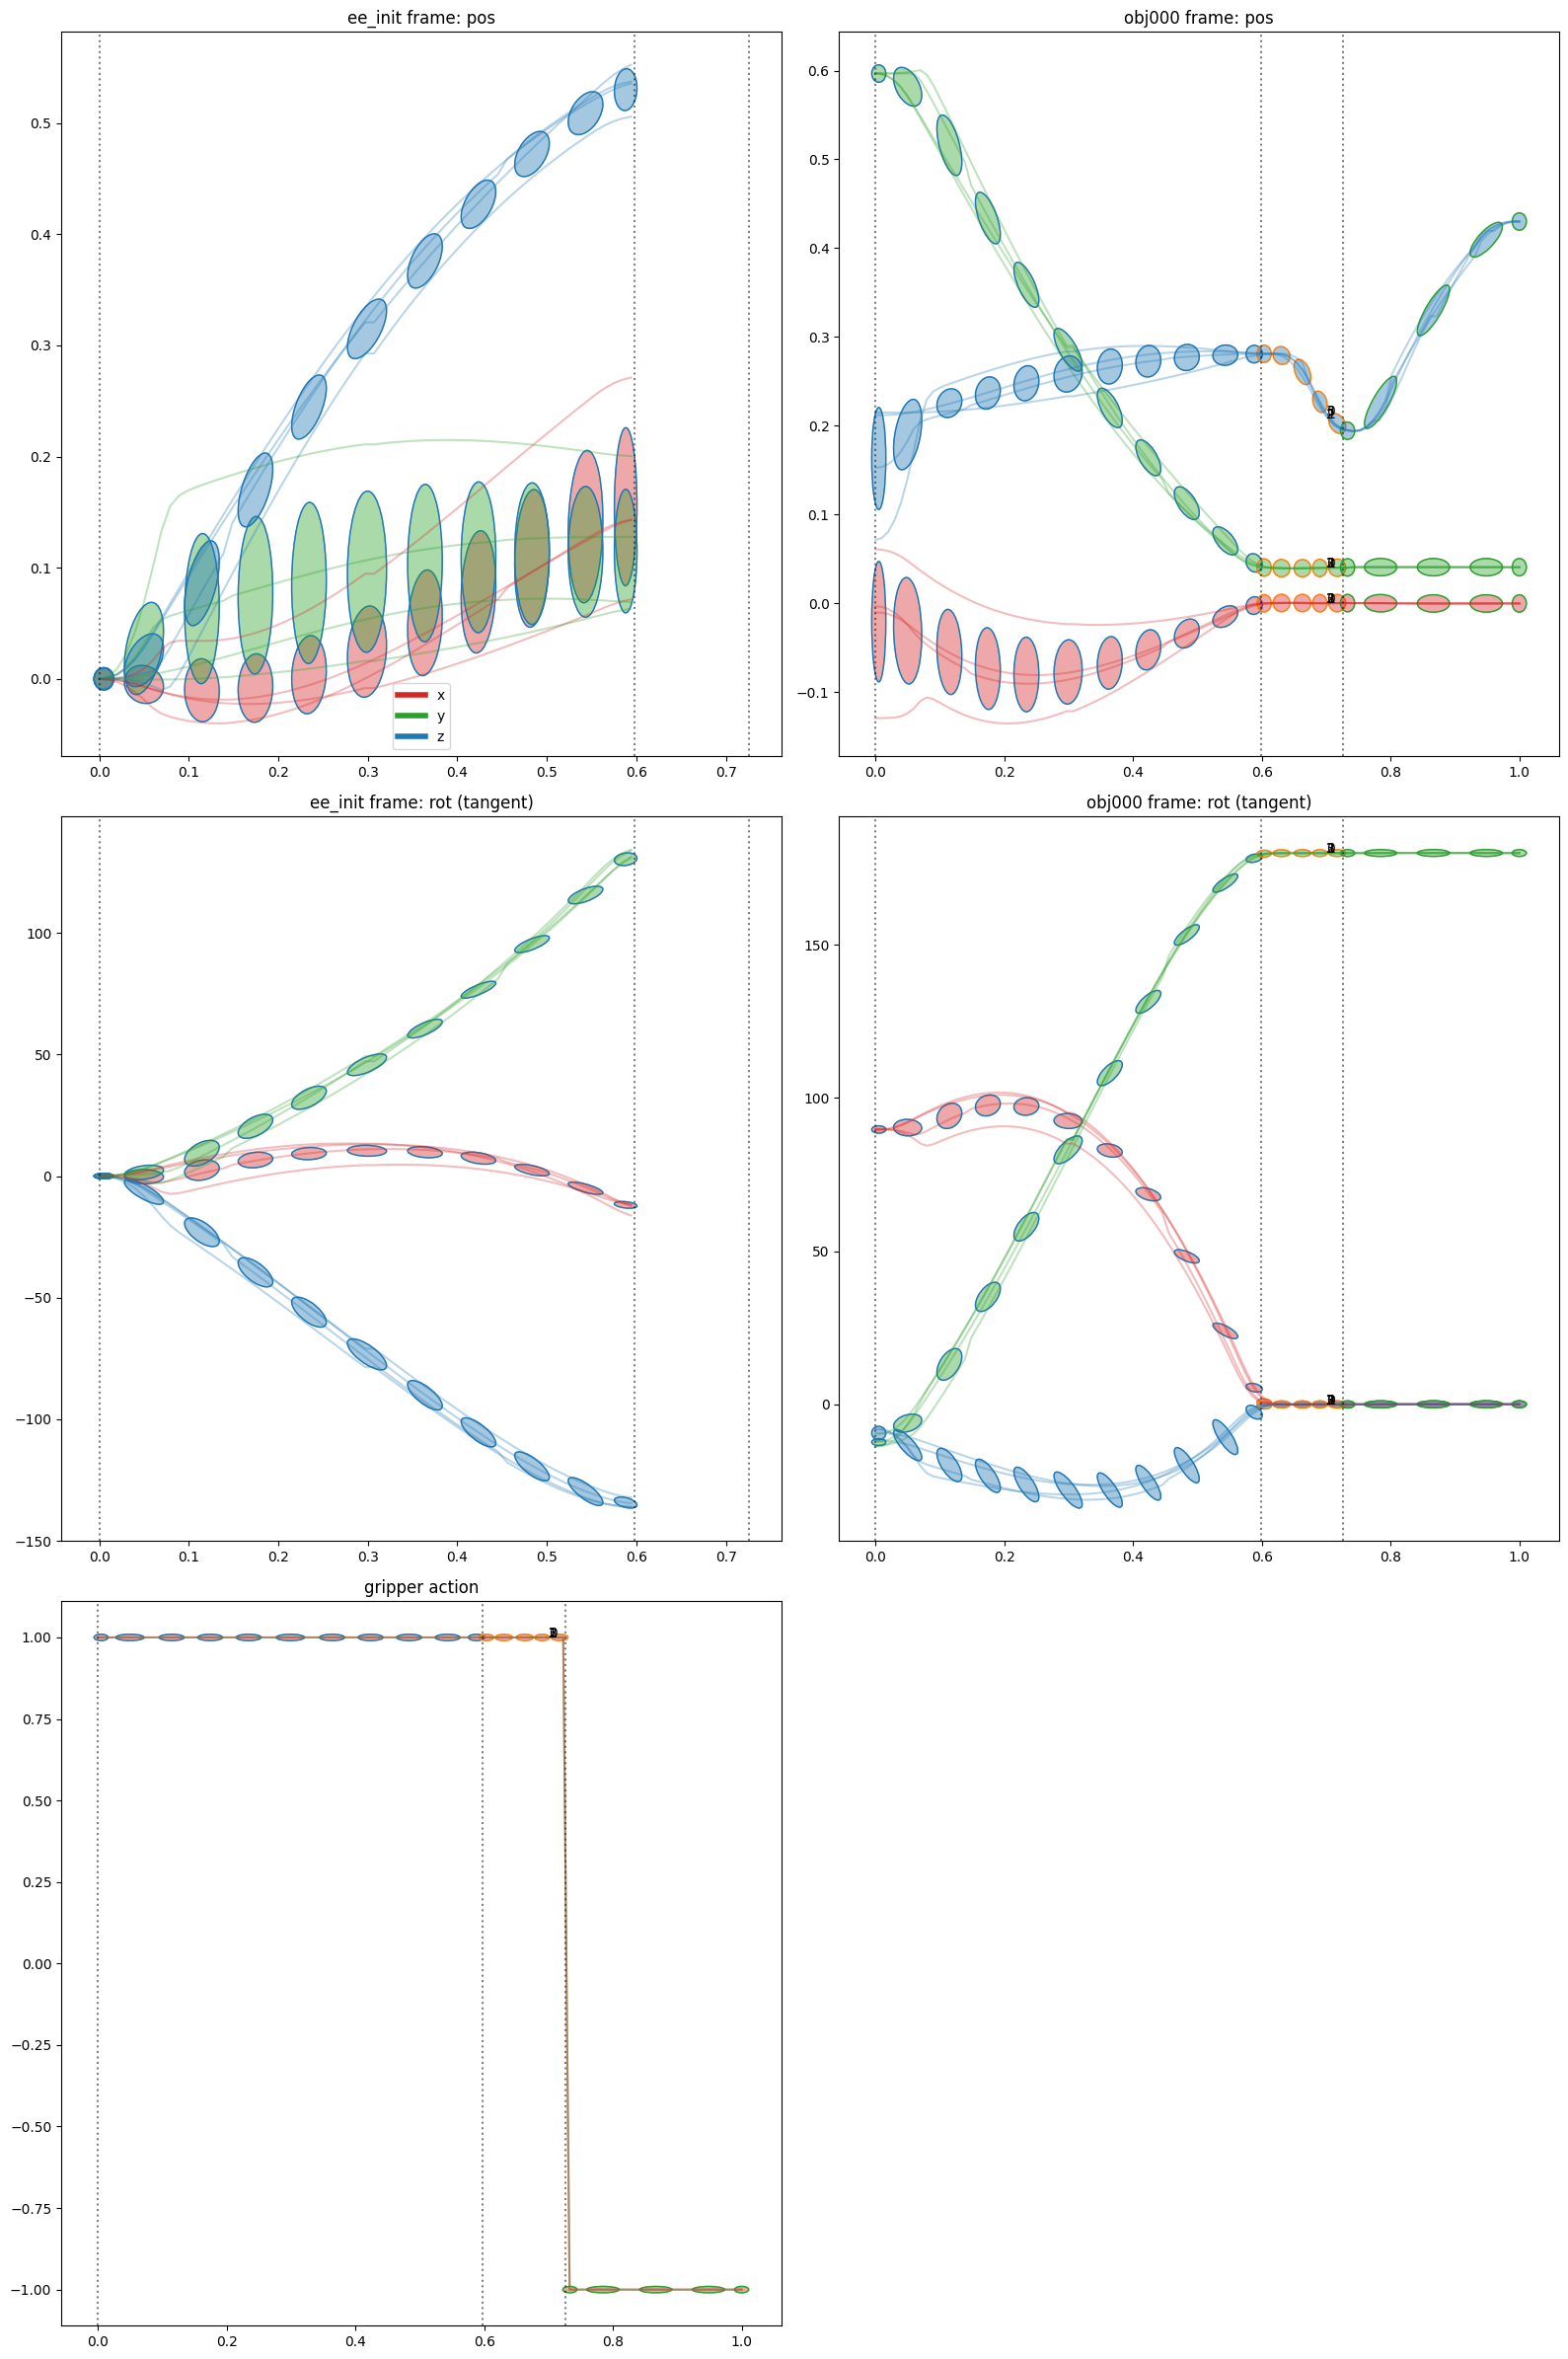

In [10]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2024-08-14 13:09:56.452 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:09:56.452 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-14 13:09:56.457 | INFO     |  HMM EM ...
2024-08-14 13:09:56.461 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-14 13:09:56.522 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-14 13:09:57.466 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1.  , 1.  , 0.97, ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.03, ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         ...,
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.05, 0.01, 0.01],
         [0.  , 0.  , 0.  , ..., 0.95, 0.99, 0.99]]),
  array([[0.96, 0.79, 0.35, 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.  , 0.97, 0.8 , 0.36, 0.06, 0.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.95, 0.78, 0.35, 0.06, 0.  , 0.  , 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.95, 0.78, 0.35, 0.06, 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.04, 0.21, 0.64, 0.91, 0.79, 0.31, 0.03, 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.  , 0.03, 0.2 , 0.64, 0.9 , 0.81, 0.41, 0.07, 0.  , 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.05, 0.22, 0.64, 0.91, 0.75, 0.19, 0.01,
          0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.22, 0.64, 0.91, 0.79,
     

2024-08-14 13:09:57.702 | INFO     |  Did not specify time_based, deciding automatically.


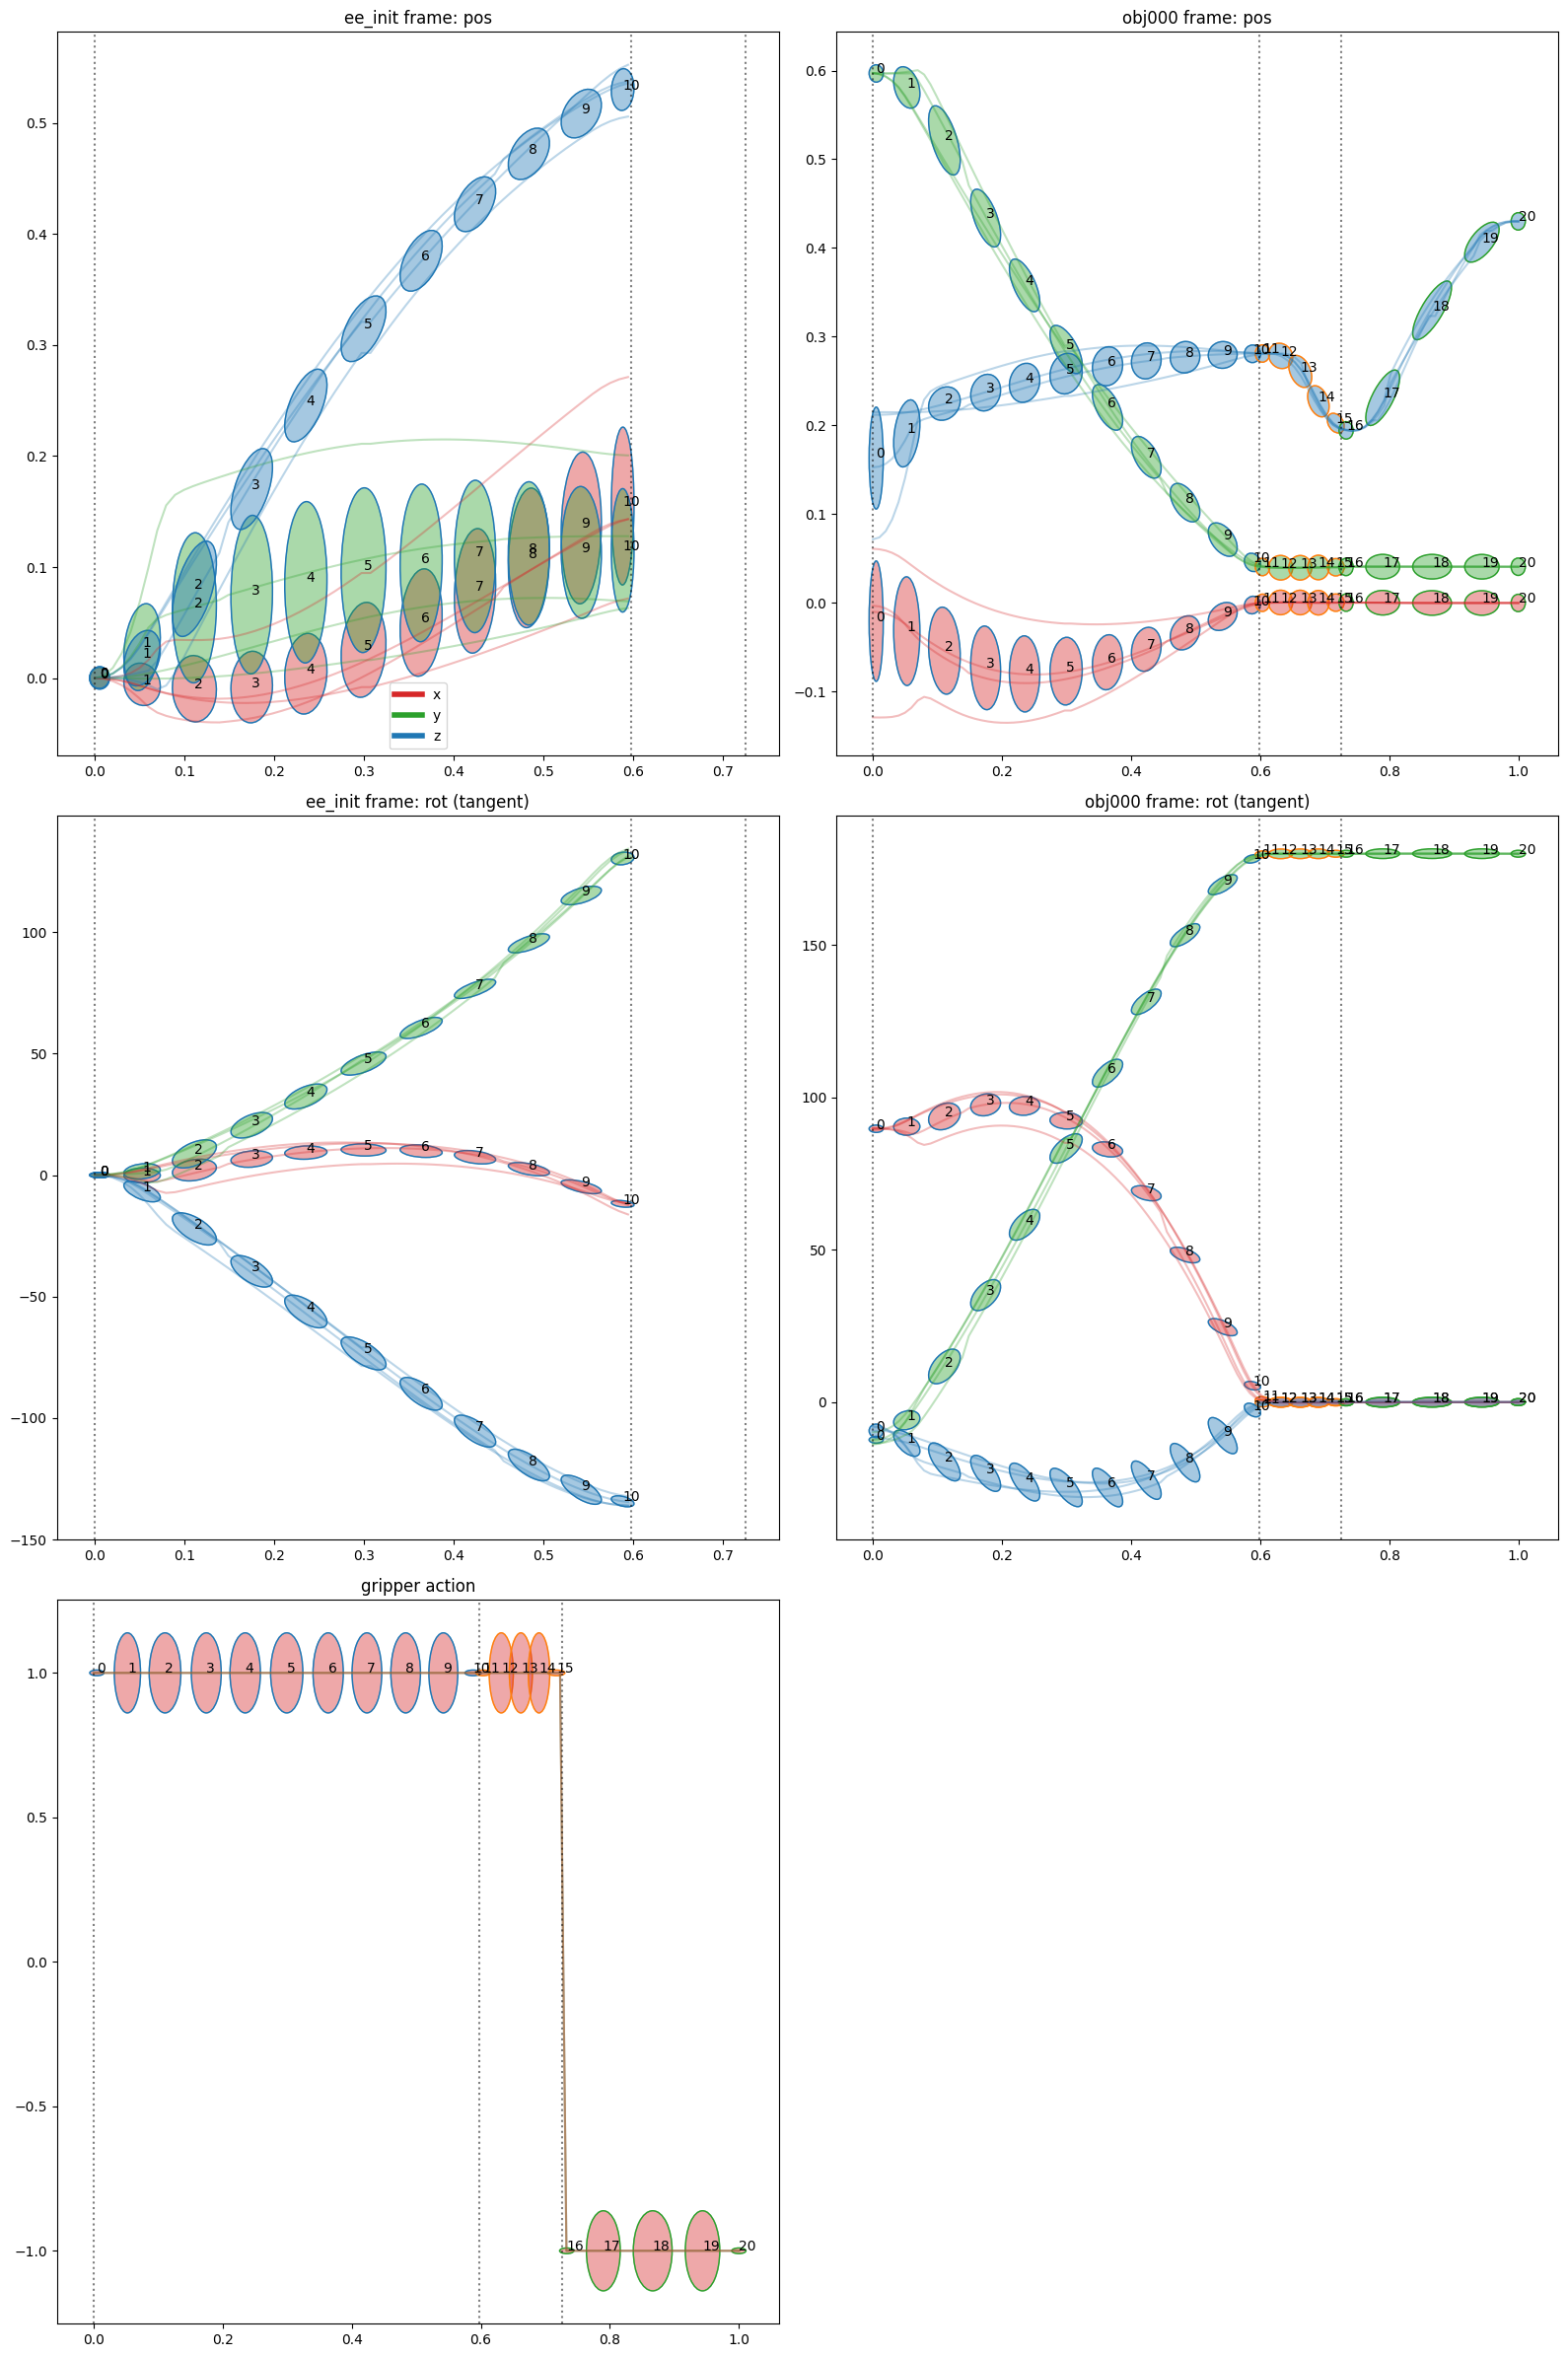

In [12]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

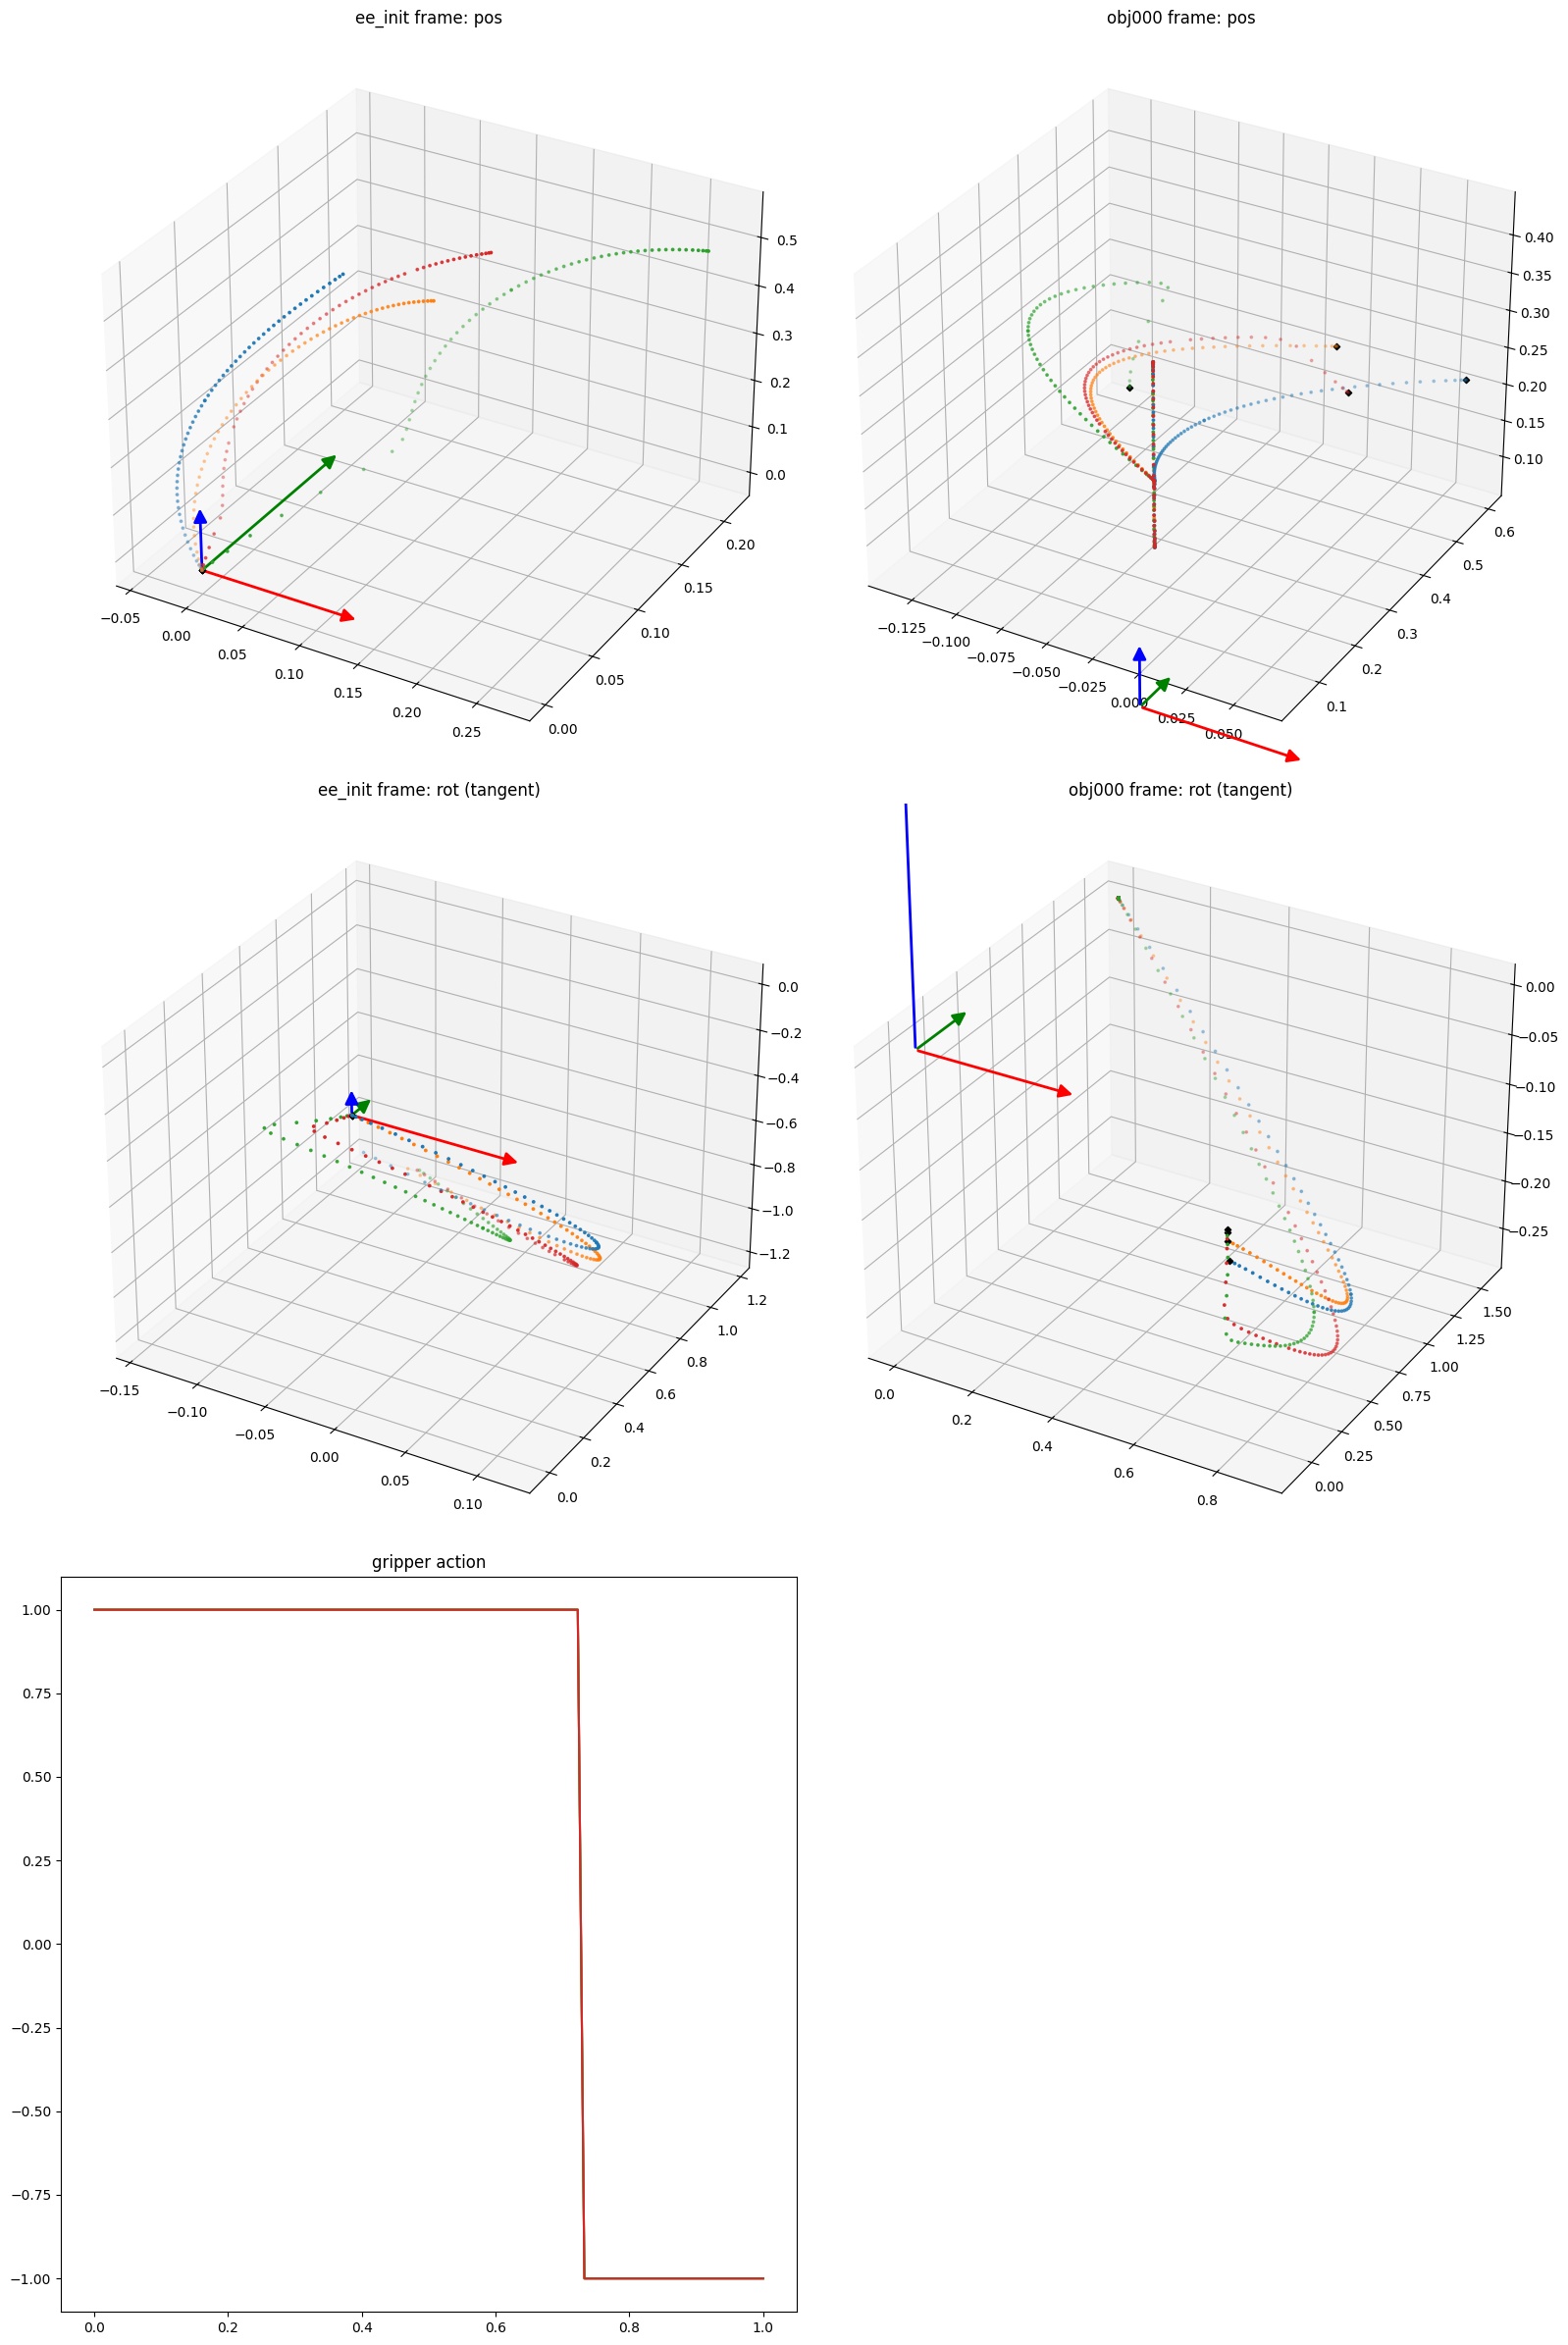

In [13]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

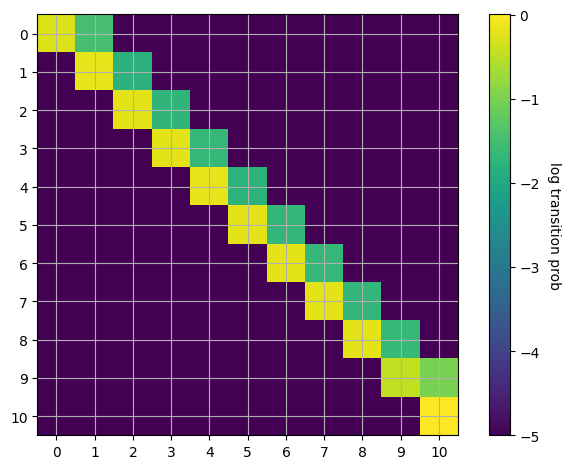

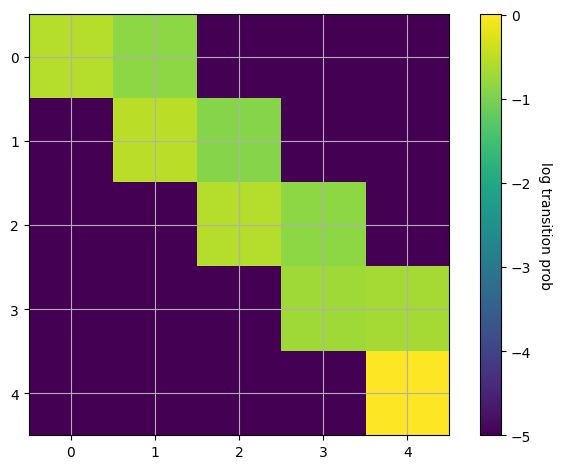

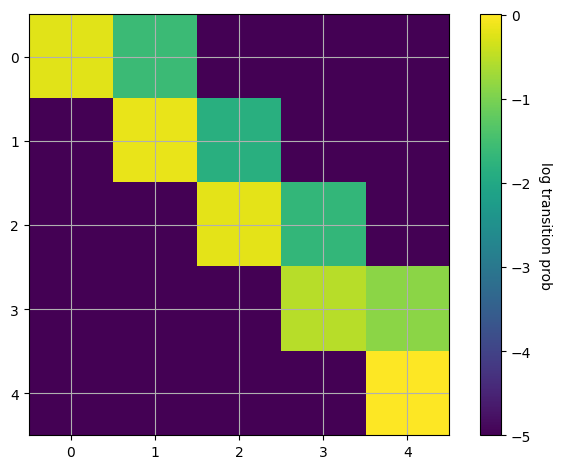

In [14]:
atpgmm.plot_hmm_transition_matrix()

In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-14 13:10:00.922 | INFO     |  Saving model:


In [16]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-14 13:10:00.998 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-14 13:10:01.026 | INFO     |  Caculated segment transition probabilities: (array([[0.84]]), array([[0.7]]))
2024-08-14 13:10:01.026 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:10:01.104 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:10:01.191 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:10:01.210 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:10:01.228 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

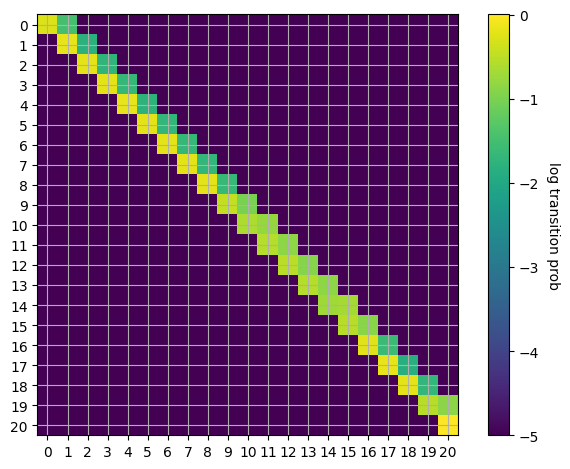

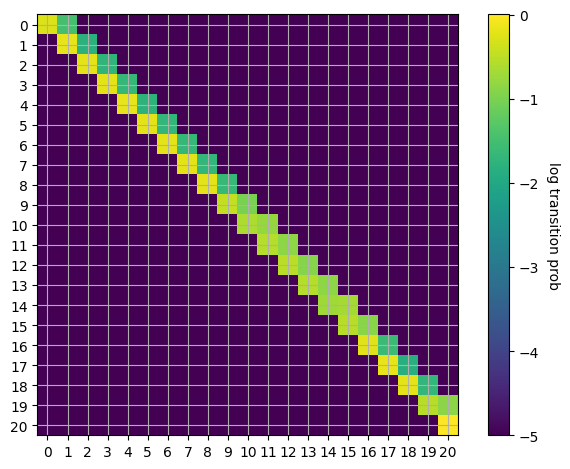

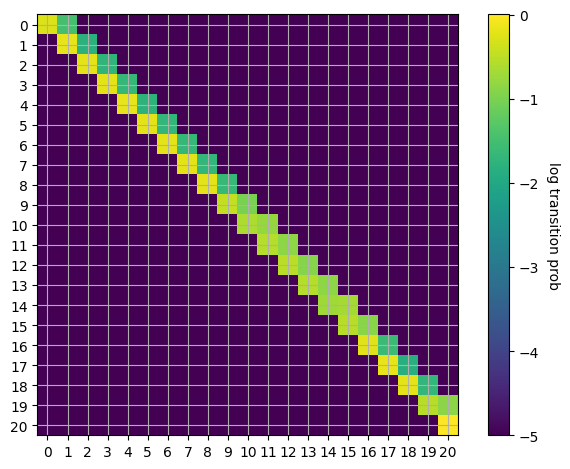

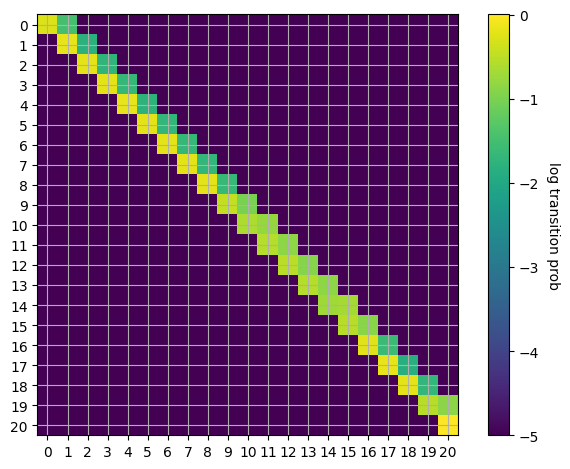

In [17]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2024-08-14 13:10:04.583 | INFO     |  Taking frame origins from demos.


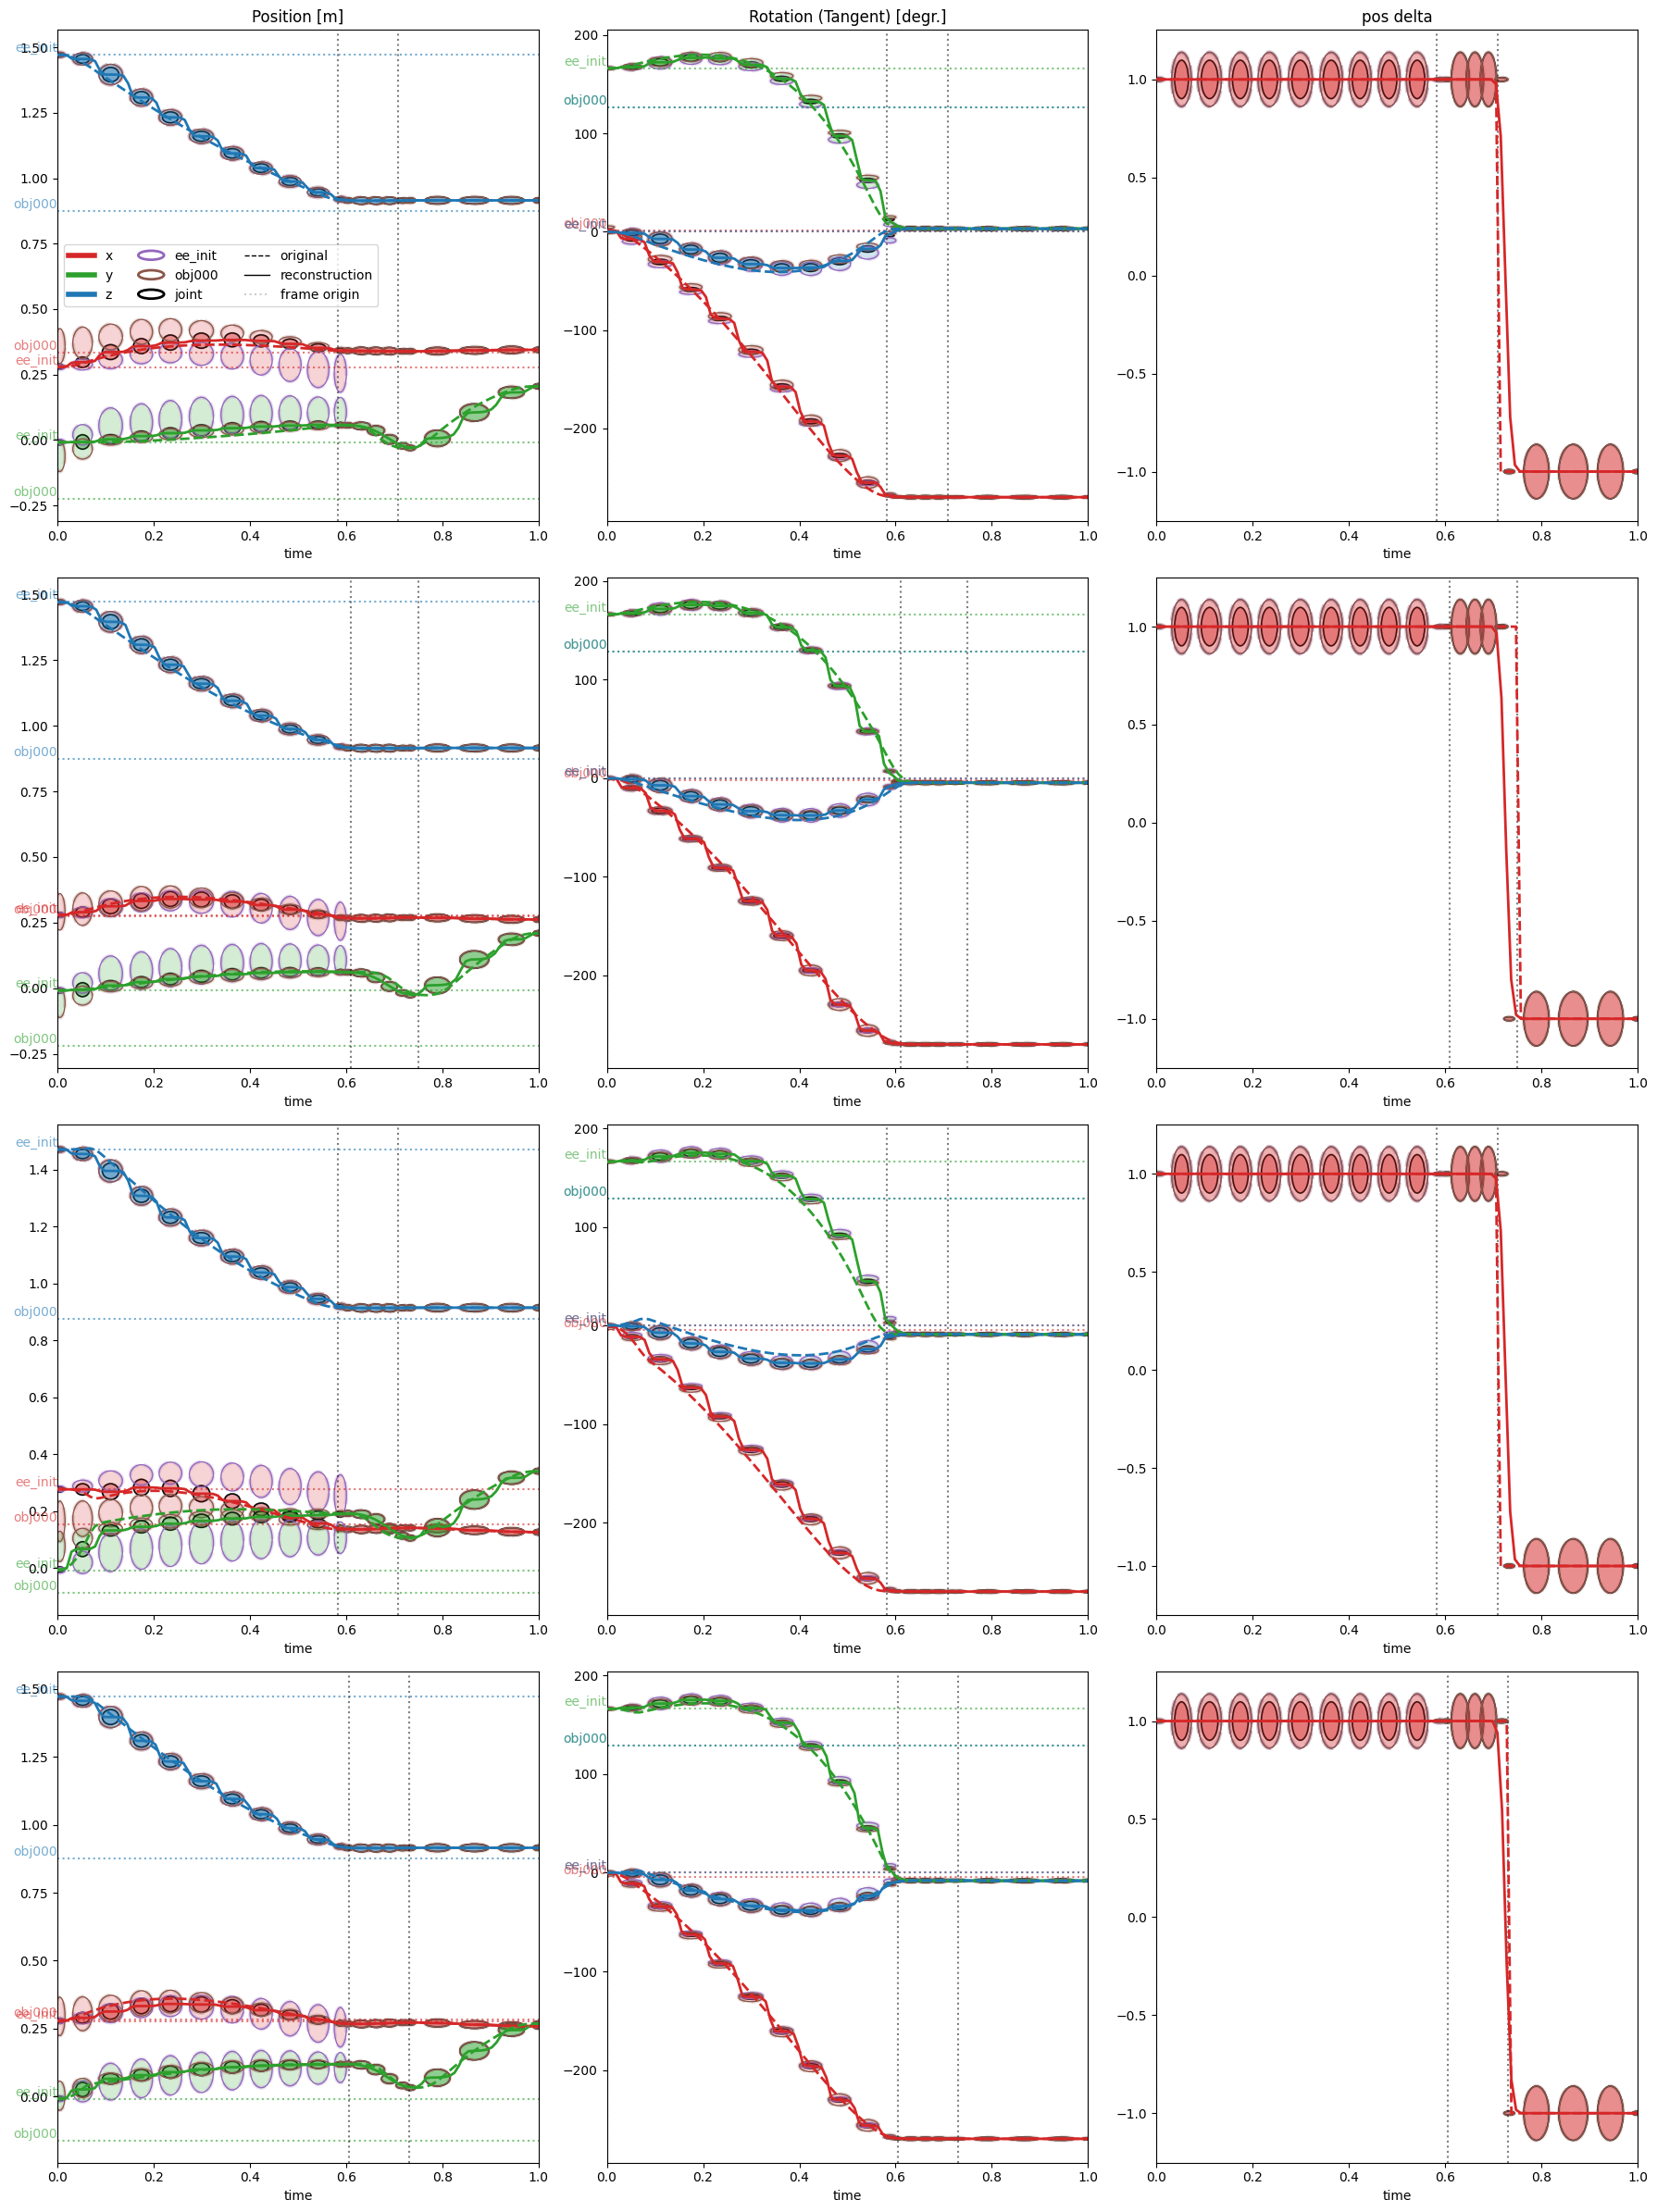

In [18]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2024-08-14 13:10:19.125 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


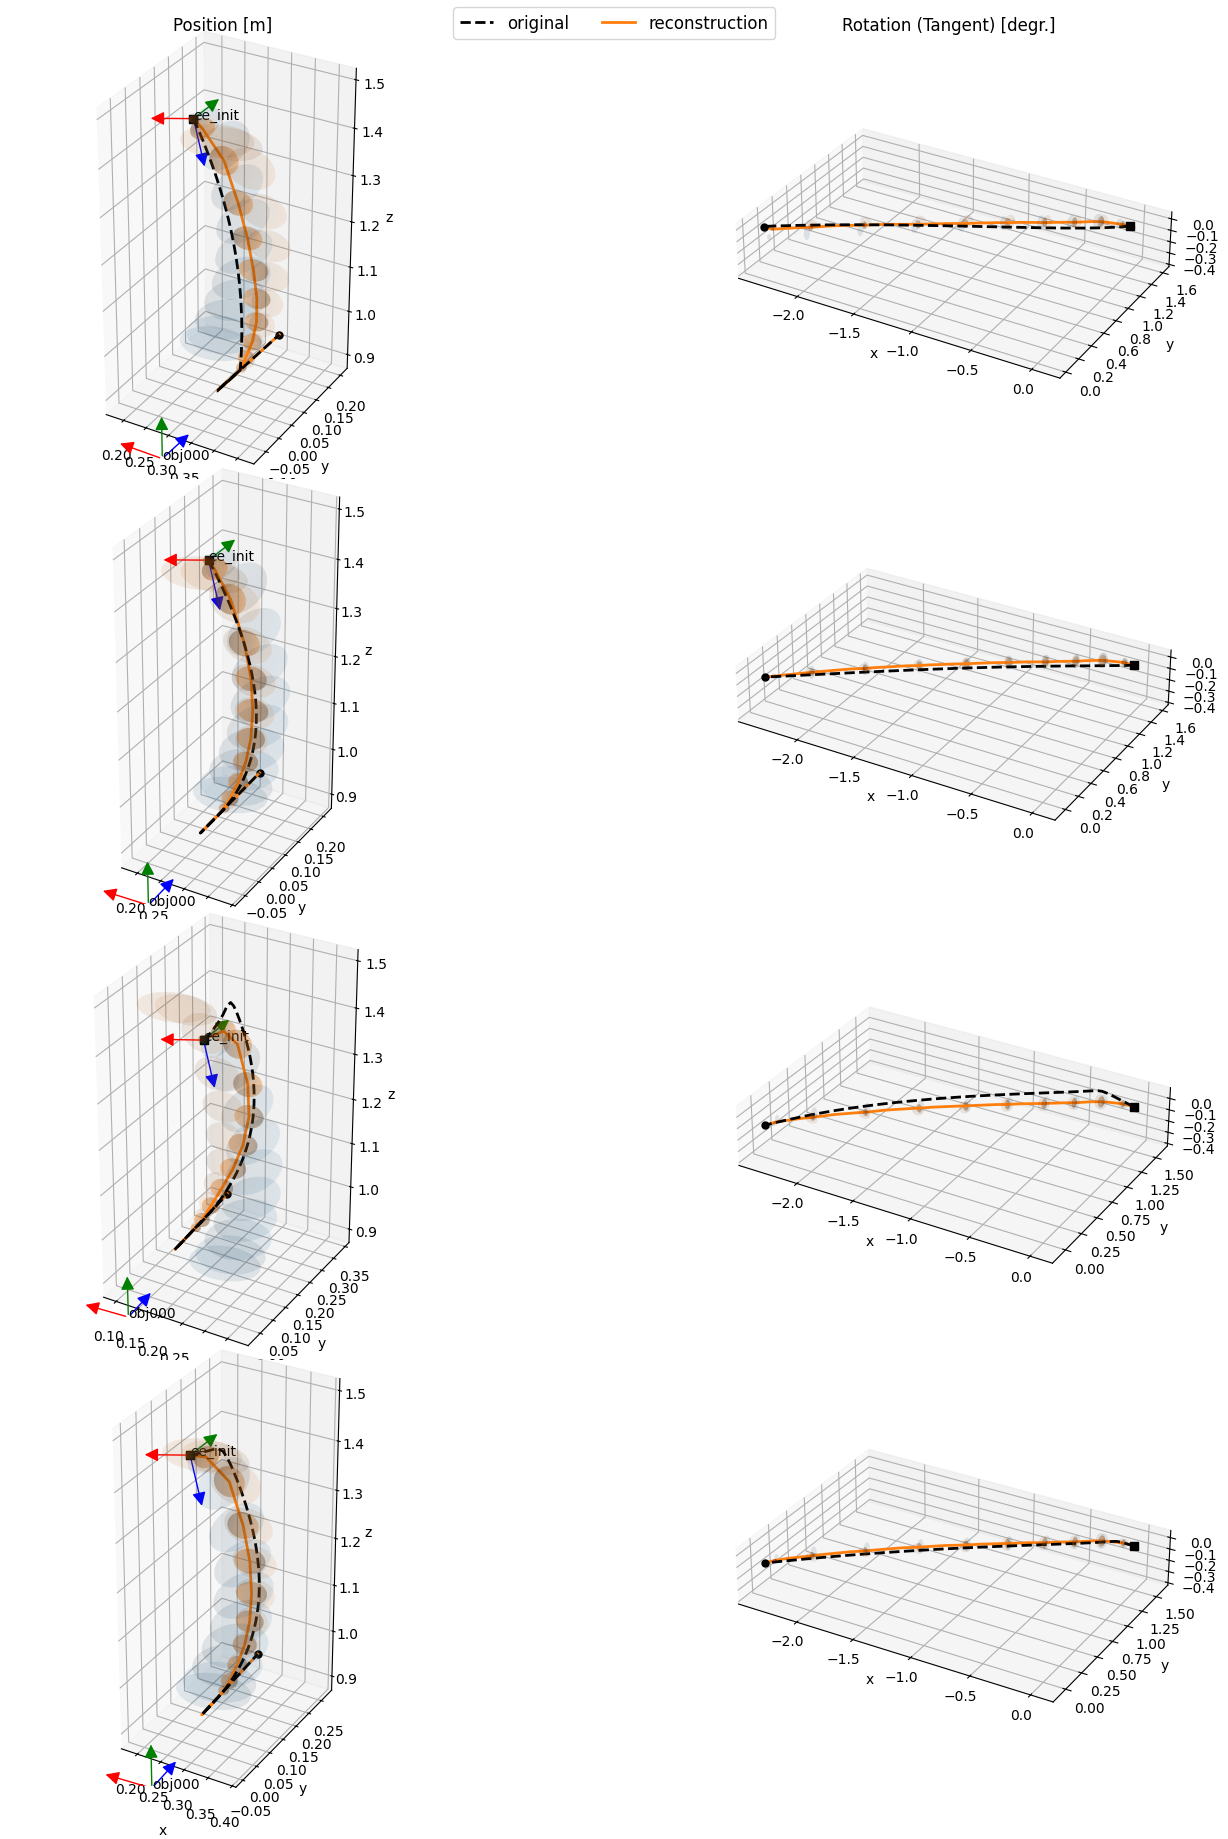

In [19]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
